In [1]:
import os
import re
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

# Catawba [05/22]


In [2]:
# Load catawba manual data
mandf0 = pd.read_excel("../data/manual/05_2022/validation_man.xlsx")

# Assume flat ground 
# Use the angle(θ) and distance from the base of the tree (d) to calculate tree height (h)

# Convert slope (%) to radians
mandf0['angle_rad'] = np.arctan(mandf0['angle']*0.01)

# angle in degrees
mandf0['angle_deg'] = np.rad2deg(mandf0['angle_rad'])

# compute tree height = tan(θ) * distance (d) + viewer height 
mandf0['height_ft'] = np.tan(mandf0['angle_rad']) * mandf0['distance'] + 5.375 # John height = 64.5 in == 5.375 ft

# Convert ft --> in 
mandf0['height'] = mandf0['height_ft'] * 12.

# Fill in the tree heights that were measured without clinometer (shorties)
mandf0['height'][np.isnan(mandf0['height_ft'])] = mandf0['height_in']

# inches to cm
mandf0['diam'] = mandf0['diam']*2.54
mandf0['height'] = mandf0['height']*2.54

# add col with measurement approaches 
mandf0['method'] = 'manual_0'

# add col with site 
mandf0['site'] = 'catawba'


<ipython-input-2-6911e18ec360>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandf0['height'][np.isnan(mandf0['height_ft'])] = mandf0['height_in']


In [3]:
# Read db dump
measurements = []
for line in open('../data/app/05_2022/bquxjob_4eb29efb_180f7d82eb2.json', 'r'):
    measurements.append(json.loads(line))

In [4]:
# extract the relevant info 
outrows = []
for idx,tree in enumerate(measurements):
    diam = float(measurements[idx]['diameter']['value']) * 2.54 # in to cm
    height = float(measurements[idx]['height']['value']) * 2.54 # in to cm
    unit = measurements[idx]['height']['unit']
    species = measurements[idx]['speciesName']
    date = measurements[idx]['captureDate']
    parcel = measurements[idx]['parcelId']
    lat = measurements[idx]['lat']
    lon = measurements[idx]['long']
    tree_id = measurements[idx]['id']
    diam_url = measurements[idx]['photos'][0]['url']
    height_url = measurements[idx]['photos'][1]['url']

    treedf = pd.DataFrame([date,lat,lon,tree_id,diam,height,species,height_url, diam_url,parcel]).T
    treedf.columns = ['date','lat','lon','tree_id','diam','height','species','height_url', 'diam_url','parcel_id']
    outrows.append(treedf)
    
# concat 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)

# Isolate field campaign dates
mask = (valdf['date'] >= "2022-05-12") & (valdf['date'] <= '2022-05-14')
appdf = valdf[mask]
appdf = appdf.sort_values(by='date', ascending = True)[1:]
pid = list(appdf['parcel_id'])[0]
appdf['parcel_id'] = pid

In [5]:
mask = (valdf['date'] >= "2022-05-12") & (valdf['date'] <= '2022-05-14')
appdf = valdf[mask]
appdf = appdf.sort_values(by='date', ascending = True)[1:]
pid = list(appdf['parcel_id'])[0]
appdf['parcel_id'] = pid

In [6]:
compdf = pd.merge(appdf, mandf0, on = 'tree_id')
compdf.rename(columns = {'diam_x':'diam_app', 'diam_y':'diam', 'height_x':'height_app', 'height_y':'height'}, inplace = True)

In [7]:
compdf.to_csv("../data/catawba_05_22.csv")

# Kentland [10/22]


In [8]:
# Load the manual dataframes
mandf1 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 1")
mandf2 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 2")

# ft --> inches 
mandf1['height_1'] = mandf1['Height (ft)'] * 12
mandf2['height_2'] = mandf2['Height (ft)'] * 12
mandf1['diam_1'] = mandf1["DBH (In)"] * 2.54 # in to cm
mandf2['diam_2'] = mandf2["DBH (In)"] * 2.54 # in to cm

# add col with measurement approaches 
mandf1['method'] = 'manual 1'
mandf2['method'] = 'manual 2'

# add col with site 
mandf2['site'] = 'kentland'
mandf1['site'] = 'kentland'

mandf1_clean = mandf1.drop(["Height (ft)", "DBH (In)"], axis = 1)
mandf2_clean = mandf2.drop(["Height (ft)", "DBH (In)"], axis = 1)

# Merge back
manual_10_22= pd.merge(mandf1_clean, mandf2_clean, right_on=['Row#','Tree#'], left_on = ['Row#','Tree#'], how='outer')
manual_10_22['height_mean'] = manual_10_22[['height_1','height_2']].mean(axis = 1)
manual_10_22['diam_mean'] = manual_10_22[['diam_1','diam_2']].mean(axis = 1)


In [9]:
# Load app sampling datasets and do lots of formatting
# Read db dump
measurements = []
for line in open('../data/app/10_2022/validation_10_2022.json', 'r'):
    measurements.append(json.loads(line))

# Extract trees line by line

outrows = []

for idx,tree in enumerate(measurements):
    try:
        diam = measurements[idx]['diameter']['value']
        height = measurements[idx]['height']['value']
        unit = measurements[idx]['height']['unit']
        species = measurements[idx]['speciesName']
        date = measurements[idx]['captureDate']
        parcel = measurements[idx]['parcelId']
        lat = measurements[idx]['lat']
        lon = measurements[idx]['long']
        tree_id = measurements[idx]['id']
        diam_url = measurements[idx]['photos'][0]['url']
        height_url = measurements[idx]['photos'][1]['url']
        notes = measurements[idx]['notes']

        treedf = pd.DataFrame([date,lat,lon,tree_id,diam,height,species,height_url, diam_url,parcel, notes]).T
        treedf.columns = ['date','lat','lon','tree_id','diam','height','species','height_url', 'diam_url','parcel_id','notes']
        outrows.append(treedf)
        
    except:
        continue
    
    
# concat 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)

# Filter out parcels with a single measurement - this leaves just Sanjok x2 and Brenda 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)
# Count n rows in each parcel 
valdf['parcel_id'].value_counts()
# record 
counts = valdf['parcel_id'].value_counts(dropna=False) 
valids = counts[counts>1].index
# filter 
appdf = valdf[valdf['parcel_id'].isin(valids)]
# Extract the indices for each tree

notescol = list(appdf['notes'])

rows = []
cols = []

for x in notescol:
    xstr = x.lower()
    rows.append(re.sub('[^0-9]','', xstr.split("p")[0]))
    cols.append(re.sub('[^0-9]','', xstr.split("p")[1]))

# Apply indices  
appdf['row'] = rows
appdf['tree_idx'] = cols

appdf['row'] = appdf['row'].astype(float)
appdf['tree_idx'] = appdf['tree_idx'].astype(float)
appdf['diam'] = appdf['diam'].astype(float) * 2.54 # in to cm
appdf['height'] = appdf['height'].astype(float) * 2.54 # in to cm 
appdf['lat'] = appdf['lat'].astype(float)
appdf['lon'] = appdf['lon'].astype(float)

appdf.replace({'parcel_id':{'5F2EA33C-65AD-4826-BF5C-D585E410C877':'User 1',
                           'A57E7C65-8B5C-43B2-9110-5A6A4ECFBC35':'User 1 repeat',
                           '48A3274A-5E61-4644-8C5E-0E856E87AF4F':'User 2'}}, inplace = True)
    


<ipython-input-9-a42473361d75>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appdf['row'] = rows
<ipython-input-9-a42473361d75>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appdf['tree_idx'] = cols
<ipython-input-9-a42473361d75>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [10]:
tdfs = []

# For each tree (unique row / col combo index), calculate mean and variance for errorbar plots 
for ridx in appdf['row'].unique():
    ardf = appdf[appdf['row']==ridx]
    mrdf = manual_10_22[manual_10_22['Row#'] == ridx]
    for tidx in appdf['tree_idx'].unique():
        atdf = ardf[ardf['tree_idx'] == tidx]
        mtdf = mrdf[mrdf['Tree#'] == tidx]
        if len(atdf) > 0 and len(mtdf) > 0:
            app_tree_df = pd.DataFrame([atdf['diam'].mean(),atdf['diam'].std(), len(atdf['diam'])]).T
            man_tree_df = pd.DataFrame([mtdf[['diam_1','diam_2']].values.mean(),mtdf[['diam_1','diam_2']].values.std(), len(mtdf[['diam_1','diam_2']].values), mtdf['SN_x'].iloc[0],mtdf['Species_x'].iloc[0]]).T
            app_tree_df.columns = ['app mean','app var','app n']
            man_tree_df.columns = ['man mean','man var','man n', 'tree idx', 'species']
            
            odf = pd.concat([app_tree_df,man_tree_df], axis = 1)
            
            tdfs.append(odf)

In [11]:
appdf_mean = pd.concat(tdfs).reset_index().drop("index", axis = 1).dropna()


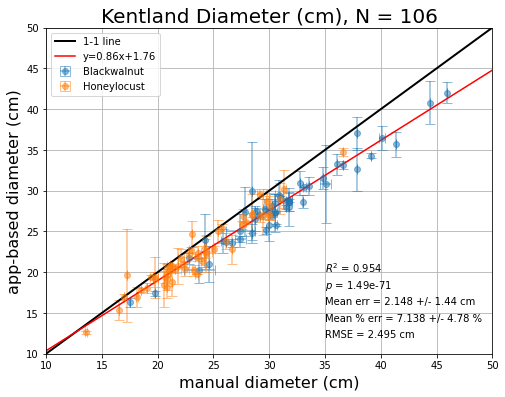

In [12]:

groups = appdf_mean.groupby('species')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.errorbar(group['man mean'],
             group['app mean'],
             yerr=group['app var'], 
             xerr = group['man var'], 
             linestyle="None", marker='o',capsize=5, label=name, markersize = 6, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,300],[0,300],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(appdf_mean['man mean'].astype(float), appdf_mean['app mean'])

# Mean absolute error
mae = np.nanmean(abs(appdf_mean['man mean'] - appdf_mean['app mean']))
mae_std = np.nanstd((appdf_mean['man mean'] - appdf_mean['app mean']))
mape = np.nanmean(((appdf_mean['man mean'] - appdf_mean['app mean']) / appdf_mean['man mean'])) * 100
mape_std = np.nanstd(((appdf_mean['man mean'] - appdf_mean['app mean']) / appdf_mean['man mean'])) * 100
rmse = ((appdf_mean['man mean'] - appdf_mean['app mean']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,300)+ intercept
plt.plot(np.linspace(0,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [35,20])
plt.annotate("$p$ = {:.2e}".format(p_value), [35,18])
plt.annotate("Mean err = {} +/- {} cm".format(str(round(mae,5))[:5],str(round(mae_std,2))), [35,16])
plt.annotate("Mean % err = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [35,14])
plt.annotate("RMSE = {} cm".format(str(round(rmse,5))[:5],), [35,12])

ax.legend()
ax.set_xlim(10,50)
ax.set_ylim(10,50)
    
plt.xlabel("manual diameter (cm)", size = 16)
plt.ylabel("app-based diameter (cm)", size = 16)


titlestr = "Kentland Diameter (cm), N = {}".format(str(len(appdf_mean)))
plt.title(titlestr, size = 20)
plt.grid()
plt.show()

In [13]:
# Load the manual dataframes
mandf1 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 1")
mandf2 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 2")

# ft --> inches 
mandf1['height_1'] = mandf1['Height (ft)'] * 12
mandf2['height_2'] = mandf2['Height (ft)'] * 12
mandf1['diam_1'] = mandf1["DBH (In)"] * 2.54 # in to cm
mandf2['diam_2'] = mandf2["DBH (In)"] * 2.54 # in to cm

# add col with measurement approaches 
mandf2['method'] = 'manual 2'
mandf1['method'] = 'manual 1'

# add col with site 
mandf2['site'] = 'kentland'
mandf1['site'] = 'kentland'

mandf1_clean = mandf1.drop(["Height (ft)", "DBH (In)"], axis = 1)
mandf2_clean = mandf2.drop(["Height (ft)", "DBH (In)"], axis = 1)

# Merge back
manual_10_22= pd.merge(mandf1_clean, mandf2_clean, right_on=['Row#','Tree#'], left_on = ['Row#','Tree#'], how='outer')
manual_10_22['height_mean'] = manual_10_22[['height_1','height_2']].mean(axis = 1)
manual_10_22['diam_mean'] = manual_10_22[['diam_1','diam_2']].mean(axis = 1)

# Filtering of app data 
appdf.loc[appdf["species"] == 'Black Locust', 'species'] = "Black Walnut"
appdf.loc[appdf["species"] == 'Honey locust', 'species'] = "Honey Locust"
appdf.rename(columns = {"parcel_id":"user"}, inplace = True)

data1 = pd.DataFrame(appdf[appdf['user']=='User 1'][['diam','user','species']])
data2 = pd.DataFrame(appdf[appdf['user']=='User 1 repeat'][['diam','user','species']])
data3 = pd.DataFrame(appdf[appdf['user']=='User 2'][['diam','user','species']])

# Filtering of manual data 
manual_10_22.loc[manual_10_22["Species_x"] == 'Honeylocust', 'species'] = "Honey Locust"
manual_10_22.loc[manual_10_22["Species_x"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["Species_y"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["Species_y"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["method_x"] == 'manual 1', 'method'] = "manual 1"
manual_10_22.loc[manual_10_22["method_y"] == 'manual 2', 'method'] = "manual 2"
# manual_10_22.rename(columns = {'method_x':'user', 'method_y':'user'}, inplace = True)

m1 = manual_10_22[['diam_1','method_x','species']].rename(columns = {'diam_1':'diam','method_x':'user'})
m2 = manual_10_22[['diam_2','method_y','species']].rename(columns = {'diam_2':'diam','method_y':'user'})
# m2['user'] = 'manual 2'

cdf = pd.concat([data1, data2, data3,m1,m2])    
# mdf = pd.melt(cdf, id_vars=['species'], var_name=['user'])


/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


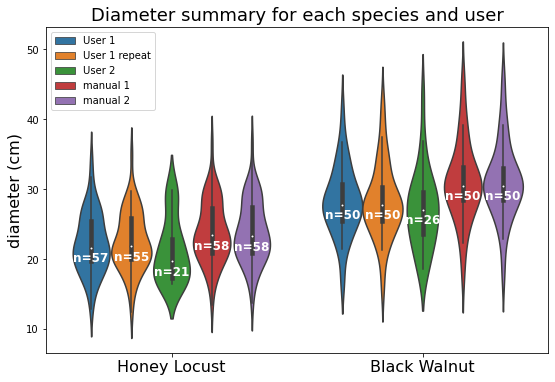

In [14]:
fig, ax = plt.subplots(figsize = (9,6))
ax = sns.violinplot(x="species", y="diam", hue="user", data=cdf)

medians = cdf.groupby(['user','species'])['diam'].median()
nobs =  cdf.groupby(['user','species']).apply(lambda x: 'n={}'.format(len(x)))

for ax in plt.gcf().axes:

    for tick, label in enumerate(ax.get_xticklabels()):
        ax_species = label.get_text()

        for j, ax_user in enumerate(ax.get_legend_handles_labels()[1]):
            x_offset = (j - (5-1)/2) * (5/((5*1)+1-1)) * 0.16
            med_val = medians[ax_user, ax_species] - 2.
            num = nobs[ax_user, ax_species]

            ax.text(tick + x_offset, med_val, num,
                    horizontalalignment='center', size='large', color='w', weight='semibold')

ax.tick_params(axis='x', labelsize=16)
plt.legend(title = None, loc = 'upper left')
plt.ylabel("diameter (cm)", size = 16)
plt.xlabel("")
plt.title("Diameter summary for each species and user", size = 18)
plt.show()

In [15]:
# Merge app + manual 
kentland_df = pd.merge(appdf, manual_10_22,  how='left', right_on=['Row#','Tree#'], left_on = ['row','tree_idx']).dropna()
# kentland_df.rename(columns = {'diam_x':'diam_app', 'diam_y':'diam', 'height_x':'height_app', 'height_y':'height', 'Species':'species'}, inplace = True)

In [16]:
# Set col names 
kentland_df['species'] = kentland_df['species_x'].replace("Honeylocust", "Honey Locust")
kentland_df['species'] = kentland_df['species_x'].replace("Blacklocust", "Black Locust")
kentland_df['species'] = kentland_df['species_x'].replace("Blackwalnut", "Black Walnut")

In [17]:
# Write
kentland_df.to_csv("../data/kentland_10_22.csv")

In [18]:
udfs = []

for u in cdf.user.unique():
    udf = cdf[cdf['user'] == u].drop(["user",'species'],axis = 1)
    udft = udf.reset_index().drop(['index'], axis = 1)
    udft.columns = [u]
    udfs.append(udft)

In [19]:
anovadf = pd.concat(udfs, axis = 1)

In [20]:
# 1/1
print("U1 M1")
print(stats.f_oneway(anovadf['User 1'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 1'].dropna(), anovadf['manual 1'].dropna()))

# 2/1
print("U2 M1")
print(stats.f_oneway(anovadf['User 1 repeat'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 1 repeat'].dropna(), anovadf['manual 1'].dropna()))

# 3/1
print("U3 M1")
print(stats.f_oneway(anovadf['User 2'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 2'].dropna(), anovadf['manual 1'].dropna()))

U1 M1
F_onewayResult(statistic=6.806690974605055, pvalue=0.009725331971270647)
LeveneResult(statistic=1.205428482958001, pvalue=0.27347896243813963)
U2 M1
F_onewayResult(statistic=5.700558450996921, pvalue=0.017841673651445355)
LeveneResult(statistic=1.5965217106214846, pvalue=0.20779110333586848)
U3 M1
F_onewayResult(statistic=6.307090157083922, pvalue=0.013063715561018784)
LeveneResult(statistic=0.06926459650062285, pvalue=0.7927646395497254)


In [21]:
# 1/2
print("U1 M2")
print(stats.f_oneway(anovadf['User 1'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 1'].dropna(), anovadf['manual 2'].dropna()))

# 2/2
print("U2 M2")
print(stats.f_oneway(anovadf['User 1 repeat'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 1 repeat'].dropna(), anovadf['manual 2'].dropna()))

# 3/2
print("U3 M2")
print(stats.f_oneway(anovadf['User 2'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 2'].dropna(), anovadf['manual 2'].dropna()))

U1 M2
F_onewayResult(statistic=7.4568982247990085, pvalue=0.006848793380008096)
LeveneResult(statistic=1.0268545631203914, pvalue=0.31204828564623477)
U2 M2
F_onewayResult(statistic=6.288914647619892, pvalue=0.012902836549748031)
LeveneResult(statistic=1.393843874939692, pvalue=0.2390861921690272)
U3 M2
F_onewayResult(statistic=6.796845389912822, pvalue=0.01003550450429822)
LeveneResult(statistic=0.04100289069986926, pvalue=0.839801356880223)


<AxesSubplot:>

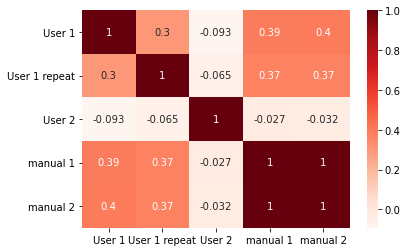

In [22]:
sns.heatmap(anovadf.corr(), cmap = 'Reds', annot=True)

In [23]:
# function for calculating the t-test for two independent samples
def independent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = np.nanmean(data1), np.nanmean(data2)
    # calculate standard errors
    se1, se2 = stats.sem(data1), stats.sem(data2)
    # standard error on the difference between the samples
    sed = np.sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = len(data1) + len(data2) - 2
    # calculate the critical value
    cv = stats.t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - stats.t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

def dependent_ttest(data1, data2, alpha):

    if not len(data1.dropna()) == len(data2.dropna()):
        dat = pd.merge(data1,data2, left_index = True, right_index = True).dropna()
        data1, data2 = dat.iloc[:,0], dat.iloc[:,1]

    # calculate means
    mean1, mean2 = np.nanmean(data1), np.nanmean(data2)
    # number of paired samples
    n = len(data2)
    # sum squared difference between observations
    d1 = sum([(data1[i]-data2[i])**2 for i in range(n)])
    # sum difference between observations
    d2 = sum([data1[i]-data2[i] for i in range(n)])
    # standard deviation of the difference between means
    sd = np.sqrt((d1 - (d2**2 / n)) / (n - 1))
    # standard error of the difference between the means
    sed = sd / np.sqrt(n)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = n - 1
    # calculate the critical value
    cv = stats.t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - stats.t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p, n

In [24]:
alpha = 0.05
t_stat, df, cv, p = independent_ttest(anovadf['User 1'].dropna(), anovadf['manual 2'].dropna(), 0.05)

print('t=%.3f, df=%d, cv=%.3f, p=%.3f' % (t_stat, df, cv, p))

# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

# interpret via p-value
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

t=-2.732, df=213, cv=1.652, p=0.007
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [25]:
alpha = 0.05
t_stat, df, cv, p, n = dependent_ttest(anovadf['User 1'], anovadf['manual 2'], 0.05)

print('t=%.3f, df=%d, cv=%.3f, p=%.3f n=%.3f' % (t_stat, df, cv, p, n))

# interpret via critical value
if abs(t_stat) <= cv:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

# interpret via p-value
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

t=-3.446, df=106, cv=1.659, p=0.001 n=107.000
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [26]:
# Jenkins equtions For mixed hardwoods 

def biom_f_dbh(dbh, treetype = 'mixed hardwoods'):
        
    if treetype == 'mixed hardwoods':
        return np.exp(-2.4800  + 2.4835 *np.log(dbh))
    if treetype == 'pine':
        return np.exp(-2.5356  + 2.4349 *np.log(dbh))
    else:
        return "Specify species"

In [29]:
for user in ['User 1', 'User 1 repeat', 'User 2', 'manual 1', 'manual 2']:
    # Convert app user measurements of carbo 
    carbon_df = biom_f_dbh(anovadf[user]) * 0.001 * 44/12 * 0.5
    samp_var = np.nansum(carbon_df - np.nanmean(carbon_df)) / len(carbon_df.dropna()-1)
    t_crit = 1.65 # for a p value of 0.05
    mean_carbon_per_tree = np.nanmean(carbon_df)
    print("USER = {}".format(user))
    print("mean carbon per tree = {} +/- {}".format(mean_carbon_per_tree, samp_var))
    unc_ded = samp_var * t_crit / mean_carbon_per_tree
    print("computed uncertainty (T CO2e) = {}".format(unc_ded))
    print("-----" * 7)

USER = User 1
mean carbon per tree = 0.4989655635413431 +/- -2.386460707138187e-17
computed uncertainty (T CO2e) = -7.891647148614782e-17
-----------------------------------
USER = User 1 repeat
mean carbon per tree = 0.5071524182650605 +/- -6.3441315692866086e-18
computed uncertainty (T CO2e) = -2.0640376960308516e-17
-----------------------------------
USER = User 2
mean carbon per tree = 0.4788534702920294 +/- 6.614094614788166e-17
computed uncertainty (T CO2e) = 2.2790387438865194e-16
-----------------------------------
USER = manual 1
mean carbon per tree = 0.6115444646791137 +/- -1.5316965802698918e-16
computed uncertainty (T CO2e) = -4.1326502052004217e-16
-----------------------------------
USER = manual 2
mean carbon per tree = 0.6154560359323412 +/- 5.037122982095618e-17
computed uncertainty (T CO2e) = 1.3504218717860537e-16
-----------------------------------
